# WMIR practice lesson

### Objective
L'obiettivo è addestrare un modello SVM sul dataset QuestionClassification usando rappresentazioni differenti e combinandole con definizioni non lineari del modello, come `polynomial` o `rbf`.  

#### Author
Claudiu Daniel Hromei, April 2023.

# Required Libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
# option to print all the value of cells in DataFrames
pd.set_option("max_colwidth", None)

# Question Classification dataset
Usiamo un dataset diverso, con l'obiettivo di classificare le domande in categorie in base al tipo di risposta ci si aspetta (es. risposta numerica, descrizione testuale o nome di persona)
Carichiamo il dataset e stampiamo le classi.

In [5]:
training_data: pd.DataFrame = pd.read_csv("./Dataset04svm/train.csv")
testing_data: pd.DataFrame = pd.read_csv("./Dataset04svm/test.csv")

classes = list(np.unique(testing_data['classes']))
print(classes)

['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']


Let's see some examples.

In [6]:
training_data.head(10)

,questions,classes
0,How did serfdom develop in and then leave Russia ?,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real names ?,DESC
3,What fowl grabs the spotlight after the Chinese Year of the Monkey ?,ENTY
4,What is the full form of .com ?,ABBR
5,What contemptible scoundrel stole the cork from my lunch ?,HUM
6,What team did baseball 's St. Louis Browns become ?,HUM
7,What is the oldest profession ?,HUM
8,What are liver enzymes ?,DESC
9,Name the scar-faced bounty hunter of The Old West .,HUM


We can plot the number of examples for each class.

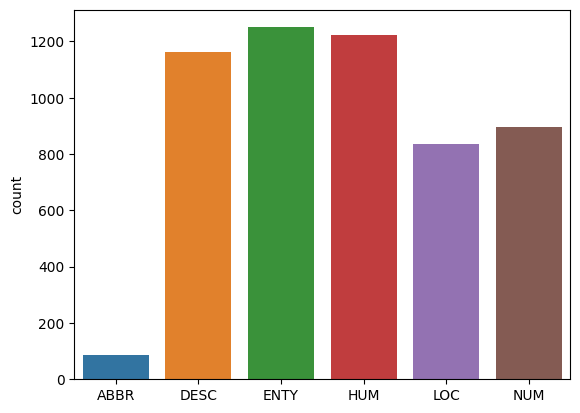

In [7]:
training_plot = sns.countplot(x=sorted(training_data['classes']))

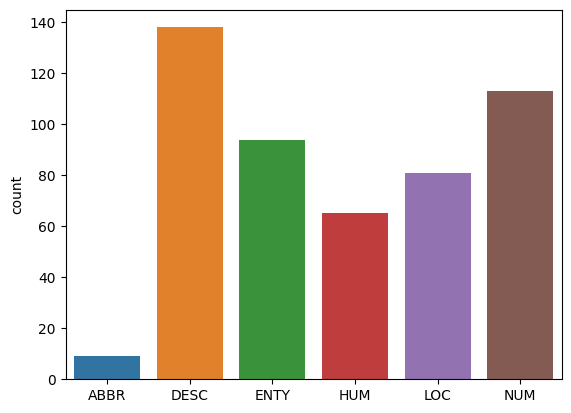

In [8]:
testing_plot = sns.countplot(x=sorted(testing_data['classes']))

# Support Vector Machines
Creiamo un modello Bag-of-Words (tf-idf) come nei precedenti esericzi, per calcolare alcuni iperpiani per la classificazione.

Panoramica dei parametri principali:

- **C**: `float`, default=`1.0`  
Parametro di regolarizzazione, che serve a ridurre l'overfitting. La forza della regolarizzazione è inversamente proporzionale a C. Deve essere strettamente positivo. La penalità è L2 (termini di regolarizzazioni al quadrato).

- **kernel**: `{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}` or callable, default=`'rbf'`  
Specifica il tipo di kernel da usare nell'algoritmo. Per default si usa il kernel `‘rbf’`. Se viene fornito un callable per pre-calcolare la matrice kernel dalle matrici dati, quella matrice dovrebbe essere della un array della forma `(n_samples, n_samples)`.

- **degree**: `int`, default=`3`  
Usato solo per la funzione kernel polinomiale (`‘poly’`). Rappresenta il grado del polinomio. Deve essere un intero non negativo.

- **gamma**: `{‘scale’, ‘auto’}` or `float`, default=`’scale’`  
Rappresenta un coefficiente kernel per una funzione Kernel tra `‘rbf’`, `‘poly’` o `‘sigmoid’`.

  - se gamma = `'scale'` (default) il valore di gamma sarà `1 / (n_features * X.var())`,
  - se gamma = `‘auto’`, il valore di gamma sarà `1 / n_features`
  - se gamma = `float`, deve esser non negativo.

- **verbose**: `bool`, default=`False`  
Attiva l'output verboso. Sconsigliato in un ambiente multithread.

- **max_iter**: `int`, default=`-1`  
Limite rigido sulle iterazioni. Se si usa -1 non c'è limite.

- **decision_function_shape**: `{‘ovo’, ‘ovr’}`, default=`’ovr’`  
Ignorato per classificazione binaria. Funzione di decisione one-vs-rest (`‘ovr’`) oppure one-vs-one (`‘ovo’`). La forma di (`‘ovr’`) è `(n_samples, n_classes)` come tutti gli altri classificatori, mentre per (`‘ovo’`) la forma è `(n_samples, n_classes * (n_classes - 1) / 2)`.

Adesso useremo un SVM con kernel `polynomial`, quindi il parametro `degree` **deve** essere definito.

## SVM - BoW

Applichiamo ancora una volta il modello Bag-of-Word per codificare le frasi in vettori tf-idf e valutare un modello SVM con kernel POLINOMIALE.

In [61]:
vectorizer = TfidfVectorizer()

# fit: Estraiamo le feature tf-idf dal dataset
# transform: convertiamo le frasi del dataset in vettori tf-idf
X_train = vectorizer.fit_transform(training_data['questions'].tolist()) # matrice sparsa del training set. 
# transform: qui convertiamo solamente le frasi del dataset
X_test = vectorizer.transform(testing_data['questions'].tolist()) # e del testing set
y_train = training_data['classes'].tolist()
y_test = testing_data['classes'].tolist()

['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR', 'HUM', 'HUM', 'HUM', 'DESC', 'HUM', 'NUM', 'DESC', 'HUM', 'HUM', 'ENTY', 'LOC', 'DESC', 'NUM', 'DESC', 'DESC', 'NUM', 'ENTY', 'HUM', 'DESC', 'DESC', 'ENTY', 'HUM', 'LOC', 'ENTY', 'LOC', 'ABBR', 'ENTY', 'NUM', 'HUM', 'NUM', 'DESC', 'NUM', 'ENTY', 'LOC', 'ENTY', 'DESC', 'ENTY', 'NUM', 'NUM', 'DESC', 'HUM', 'ENTY', 'HUM', 'DESC', 'ENTY', 'LOC', 'DESC', 'HUM', 'DESC', 'HUM', 'DESC', 'ENTY', 'ENTY', 'LOC', 'DESC', 'LOC', 'DESC', 'LOC', 'DESC', 'HUM', 'LOC', 'DESC', 'DESC', 'LOC', 'DESC', 'LOC', 'HUM', 'ENTY', 'DESC', 'HUM', 'DESC', 'HUM', 'ENTY', 'DESC', 'LOC', 'ENTY', 'NUM', 'DESC', 'LOC', 'ENTY', 'NUM', 'LOC', 'ENTY', 'HUM', 'NUM', 'NUM', 'DESC', 'DESC', 'ENTY', 'DESC', 'DESC', 'HUM', 'DESC', 'NUM', 'LOC', 'HUM', 'DESC', 'DESC', 'ENTY', 'HUM', 'HUM', 'DESC', 'LOC', 'ENTY', 'LOC', 'DESC', 'LOC', 'LOC', 'ENTY', 'ENTY', 'ENTY', 'LOC', 'NUM', 'ENTY', 'DESC', 'LOC', 'ENTY', 'DESC', 'NUM', 'DESC', 'DESC', 'DESC', 'HUM', 'HUM', 'NUM', 'ENTY', 'DESC', 'ENT

In [10]:
C = 1
decision_function_shape_values = 'ovr' 
max_iter = -1
kernel = "poly"
degree = 5
gamma = 4

In [12]:
svm = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape_values)
# addestriamo SVM polinomiale per classificazione multiclasse
svm.fit(X_train, y_train)
# prediciamo il testing set
y_pred = svm.predict(X_test)
# vediamo come va:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       0.67      0.44      0.53         9
        DESC       0.84      0.76      0.80       138
        ENTY       0.35      0.86      0.50        94
         HUM       0.58      0.82      0.68        65
         LOC       0.87      0.25      0.38        81
         NUM       0.95      0.19      0.31       113

    accuracy                           0.57       500
   macro avg       0.71      0.55      0.53       500
weighted avg       0.74      0.57      0.54       500



Abbiamo il 57% di accuratezza. Si può fare di meglio. Proviamo a variare il grado del polinomio con la 5-fold cross-validation, prima grado 3 e poi 4.

In [14]:
from sklearn.model_selection import cross_val_score
# proviamo a ca
scores = []
degrees_list = [3,4]
for d in degrees_list:
    print("degree:", d)
    svm = SVC(C=C, max_iter=max_iter, degree=d, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape_values)
    mean_score = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1_macro").mean()
    print("f1 macro: ", mean_score)
    scores.append((d, mean_score))
    print(20*"-")

degree: 3
f1 macro:  0.6510732388958493
********************
degree: 4
f1 macro:  0.47072928788254476
********************


Quindi con grado 4 e 5 il modello è troppo complesso. 3 sembra il grado migliore per il kernel polinomiale in SVM.

---

Proviamo adesso a usare una funzione kernel più avanzata: la Radial Basis Function (`rbf`). 
E' definita come l'esponenziale della distanza Euclidea al quadrato tra due vettori di feature in uno spazio, moltiplicata per un parametro `gamma`. L'output di questa funzione kernel varia da 0 a 1 e può essere visto come una **misura di similarità**: 0 molto diversi, 1 molto simili.

$$K(\bold{x},\bold{x}') = e^{-\gamma \|\bold{x}-\bold{x}'\|^2}$$

In [23]:
# Come prima, ma stavolta il kernel è rbf. degree non serve. Con gamma = 3 migliora molto. Con gamma = 2 ancora meglio!!!
svm = SVC(C=C, max_iter=max_iter, kernel='rbf', gamma=gamma, decision_function_shape='ovr')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       0.67      0.44      0.53         9
        DESC       0.81      0.78      0.79       138
        ENTY       0.34      0.93      0.50        94
         HUM       0.71      0.85      0.77        65
         LOC       1.00      0.20      0.33        81
         NUM       1.00      0.09      0.16       113

    accuracy                           0.56       500
   macro avg       0.75      0.55      0.51       500
weighted avg       0.78      0.56      0.51       500



Purtroppo non migliora le cose... Ma proviamo a cambiare gamma

In [43]:
from sklearn.model_selection import cross_val_score
# proviamo a cambiare gamma!
scores = []
gamma_list = [1,2,3,4, 'auto']
best_model_tfidf = None
best_score = 0
for gamma in gamma_list:
    print("gamma:", gamma)
    svm = SVC(C=C, max_iter=max_iter, kernel='rbf', gamma=gamma, decision_function_shape=decision_function_shape_values)
    mean_score = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1_macro").mean()
    if best_model_tfidf == None or mean_score > best_score:
        best_model_tfidf = svm
        best_score = mean_score
    print("f1 macro: ", mean_score)
    scores.append((gamma, mean_score))
    print(20*"-")

print(best_model_tfidf)

gamma: 1
f1 macro:  0.8039368236744349
--------------------
gamma: 2
f1 macro:  0.7498467002092241
--------------------
gamma: 3
f1 macro:  0.5721278345122933
--------------------
gamma: 4
f1 macro:  0.36185271429888843
--------------------
gamma: auto
f1 macro:  0.06217050467275851
--------------------
SVC(C=1, gamma=1)


I migliori risultati si hanno per gamma = 1 oppure gamme = 'scale'

## Neural Encodings

Definition of the model using a different policy to compute the representation of the test. Recently, advanced models were introduced,  called [Transformers](https://jalammar.github.io/illustrated-transformer/) able to represent words in context (in the sentence): e.g. the word *bank* has at least two differnt meanings, depending on the sentence in which is found  
- "*The **bank** of the river.*"  
- "*I asked the **bank** for a loan*".  

These Transformers will produce different representations based on the context. On the other hand, the classic Bag-of-Words approach will produce the same representation either for the side of the river and the financial institution.

We can leverage the ability of the Transformers in order to produce the numerical representation of the sentences from our dataset and then use the SVM model for classification. The `get_embeddings` method here calls the Transformer named `'msmarco-distilbert-base-v2'` to get the numerical representation in a similar manner as we called the Vectorizer to produce the `tf-idf` vectors previously.  

More about the Transformers topic in the next lessons!

Take away: *we are injecting contextual knowledge into the SVM model*!

---

**WARNING**: you need to activate the GPU setting for this notebook. If you're using the Jupyter Notebook Environment pass over this, if you're using the Google Colab environment you need to:  
- click on "*Runtime*"
- click on "*Change Runtime type*"
- on "*Hardware accelerator*" choose "*GPU*" from the dropdown list
- click on *Save* and run this Notebook again

I already computed this embeddings and we will load them from file. If you want to use this model and compute them for yourself, execute this in a code cell:

```
# install the library
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
import torch

def get_embeddings(sentences: List[str]) -> List[float]:
    model = SentenceTransformer('msmarco-distilbert-base-v2')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model.encode(sentences, batch_size=640, device="cuda:0", show_progress_bar=True).tolist()

X_train_sbert = get_embeddings(newsgroups_train.data)
X_test_sbert = get_embeddings(newsgroups_test.data)
```

Load the embeddings from file here and print the first question and its embedding.

In [75]:
X_train_sbert = []
with open("./Dataset04svm/train_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_train_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])
    
X_test_sbert = []
with open("./Dataset04svm/test_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_test_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])

In [52]:
print(training_data['questions'].tolist()[20], "\n", X_train_sbert[20])

What is the date of Boxing Day ? 
 [-0.30974090099334717, 0.50898277759552, 0.08072645962238312, -0.9401206970214844, -0.8128250241279602, -0.6734052896499634, -0.01927994191646576, 0.9211580157279968, 1.4949185848236084, 0.20072388648986816, -0.20275887846946716, 0.16153311729431152, -0.2628682851791382, -0.17560765147209167, -0.21005120873451233, 0.8293363451957703, -0.08906467258930206, -0.1669425219297409, 0.218394473195076, 0.07574951648712158, -0.4972553849220276, 0.40407174825668335, 0.06028851866722107, 0.7163890600204468, 0.3213236629962921, 0.9732807278633118, 0.07892663776874542, 0.43038350343704224, 0.286204993724823, 0.04079986363649368, 0.6179925203323364, -0.15243706107139587, -0.37264516949653625, 0.6823400259017944, -0.19847342371940613, 0.30428916215896606, 0.9350379705429077, 0.8051928281784058, -0.5906075239181519, 0.5509642362594604, -0.5492445826530457, -0.07955031096935272, 0.8939704895019531, 0.1667163372039795, -1.0867096185684204, 0.4705183506011963, 0.5635088

Let's take 2 similar questions and a very different one. We take their texts, their indexes, we can apply the *PCA* to compute the first 3 eigen-vectors and plot them as the previous lessons to visualize the representations in the vectorial space.

In [53]:
q1 = "What is the date of Boxing Day ?"
q1_index = training_data.index[training_data['questions'] == q1].tolist()[0]

q2 = "What is the date of Bastille Day ?"
q2_index = training_data.index[training_data['questions'] == q2].tolist()[0]

q3 = "Where can I find a case on Individuals with Disabilities Education Act of 1991 ?"
q3_index = training_data.index[training_data['questions'] == q3].tolist()[0]

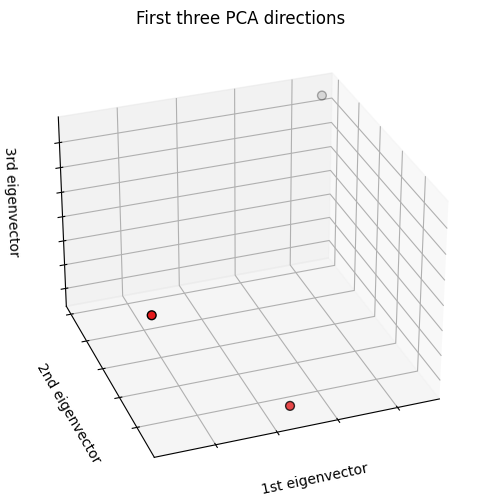

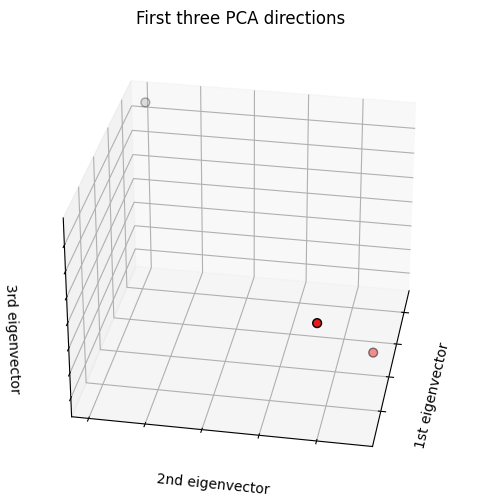

In [54]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X_train_sbert)
X_reduced_selected = [X_reduced[q1_index].tolist(), X_reduced[q2_index].tolist(), X_reduced[q3_index].tolist()]

ax.scatter(
    [x[0] for x in X_reduced_selected], # asse x
    [x[1] for x in X_reduced_selected], # asse y
    #[0, 0, 0], # asse z
    [x[2] for x in X_reduced_selected],
    c=[y_train.index(y_train[q1_index]), y_train.index(y_train[q2_index]), y_train.index(y_train[q3_index])],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

### second plot ###
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=170)

ax.scatter(
    [x[0] for x in X_reduced_selected], # asse x
    [x[1] for x in X_reduced_selected], # asse y
    #[0, 0, 0], # asse z
    [x[2] for x in X_reduced_selected],
    c=[y_train.index(y_train[q1_index]), y_train.index(y_train[q2_index]), y_train.index(y_train[q3_index])],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

The two red dots are `q1` and `q2`, very similar questions, both concerning the dates of two events. Notice how close they are in this 3D space.  
The gray one is `q3`, concerning some Educational Act, that is in the very far corner of the space with respect to the other two.

#### Embedding con SVM
Addestriamo un modello SVM con kernel **polinomiale** e rappresentazione word embedding di BERT delle frasi.

In [143]:
svm_poly_with_bert = SVC(C=1, degree=3, kernel='poly', gamma=1.0, decision_function_shape='ovr')

svm_poly_with_bert.fit(X_train_sbert, y_train)
y_pred_sbert = svm_poly_with_bert.predict(X_test_sbert)

print(classification_report(y_test, y_pred_sbert, target_names=classes))

              precision    recall  f1-score   support

        ABBR       1.00      0.67      0.80         9
        DESC       0.85      0.97      0.91       138
        ENTY       0.82      0.85      0.84        94
         HUM       0.88      0.94      0.91        65
         LOC       0.93      0.86      0.90        81
         NUM       1.00      0.84      0.91       113

    accuracy                           0.89       500
   macro avg       0.92      0.86      0.88       500
weighted avg       0.90      0.89      0.89       500



Addestriamo un modello SVM con kernel **rbf** e rappresentazione word embedding di BERT delle frasi.

In [171]:
svm_rbf_with_bert = SVC(C=1.5, max_iter=-1, degree=0, kernel='rbf', gamma='scale', decision_function_shape='ovr')

svm_rbf_with_bert.fit(X_train, y_train)

y_pred = svm_rbf_with_bert.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.81      1.00      0.90       138
        ENTY       0.84      0.74      0.79        94
         HUM       0.92      0.89      0.91        65
         LOC       0.86      0.85      0.86        81
         NUM       0.99      0.85      0.91       113

    accuracy                           0.88       500
   macro avg       0.90      0.85      0.87       500
weighted avg       0.88      0.88      0.88       500



### Exercise 1: Create a mini test set

Create some questions (20, 30, ... 100) and assign them a label accordingly to this dataset (e.g. `DESC` or `LOC`). Then take the best model you trained until now, make the predictions on this invented questions and evaluate it. Provide the `classification_report` output as shown before.

```
new_questions = [
    "Where was Napoleon born?",
    ...
]

new_labels = [
    "LOC",
    ...
]
```

---
**WARNING**: You need to use the BoW representations OR invoke the Transformer model on Colab to get the neural encodings.

In [79]:
new_questions = [
    "Where was Napoleon born?",
    "What is a rbf kernel?",
    "Why Napoleon lost at Waterloo?",
    "Which color is Napoleon's horse?",
    "When was Napoleon born?",
    "Who was Napoleon?",
    "What was Napoleon's favourite dish?",
    "What means U.S.A.?"
]

new_labels = [
    'LOC',
    'DESC',
    'DESC',
    'ENTY',
    'NUM',
    'HUM',
    'ENTY',
    'ABBR'
]

In [39]:
%pip install sentence-transformers


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Soluzione esercizio 1 con SVM e embeddings

In [89]:
from sentence_transformers import SentenceTransformer
import torch
from typing import List

def get_embeddings(sentences: List[str]) -> List[float]:
    model = SentenceTransformer('msmarco-distilbert-base-v2')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model.encode(sentences, batch_size=640, device="cuda:0", show_progress_bar=True).tolist()

# servono solo le features
X_mini_test_sbert = get_embeddings(new_questions)

print(X_mini_test_sbert[0])
print(X_mini_test_sbert[1])
print(X_mini_test_sbert[2])
print(X_mini_test_sbert[3])
print(X_mini_test_sbert[4])
print(X_mini_test_sbert[5])
print(X_mini_test_sbert[6])
print(X_mini_test_sbert[7])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[-0.49412864446640015, -0.12115715444087982, -0.744407057762146, 0.28123342990875244, 0.3222176134586334, 0.8318082094192505, -0.024174341931939125, 1.2038755416870117, 0.23369838297367096, -0.20294031500816345, -0.3241601586341858, 0.4500731825828552, 0.6152830719947815, -0.5519326329231262, 0.2852204442024231, 0.25494644045829773, 0.06495165079832077, -0.03436283394694328, -0.44523054361343384, 0.7563385963439941, 0.1460696905851364, -0.11962806433439255, -0.057753417640924454, 0.10194943100214005, 0.4195961058139801, -0.08470471203327179, -0.05478852987289429, 0.9375136494636536, -0.15499985218048096, -0.3286186754703522, -0.8789678812026978, -0.24607455730438232, 0.5748735070228577, 0.8641594648361206, -0.8615044951438904, -0.495414674282074, -0.35086292028427124, -0.1960725635290146, 0.35663869976997375, 0.23552702367305756, -0.07322903722524643, -0.26676011085510254, 0.7638670802116394, -0.271043062210083, -0.17971934378147125, -0.16304656863212585, 0.0331445075571537, 0.10585331

In [97]:
# eseguiamo le predizioni con kernel polinomiale e embeddings
best_svm = SVC(C=1, max_iter=-1, kernel='poly', degree=3, gamma=1, decision_function_shape='ovr')
best_svm = best_svm.fit(X_train_sbert, y_train)
y_pred_newtest = best_svm.predict(X_mini_test_sbert)
print("best predicted: ", y_pred_newtest)
print("actual:\t", new_labels)
print(classification_report(new_labels, y_pred_newtest, target_names=classes))

dumb_svm = SVC(C=1, max_iter=-1, kernel='rbf', gamma=4, decision_function_shape='ovr')
dumb_svm.fit(X_train_sbert, y_train)
y_pred_newtest_dumb = dumb_svm.predict(X_mini_test_sbert)
print("dumb predicted: ", y_pred_newtest_dumb)
print("actual:\t", new_labels)
print(classification_report(new_labels, y_pred_newtest_dumb, target_names=classes, zero_division=0))

best predicted:  ['LOC' 'DESC' 'ENTY' 'ENTY' 'NUM' 'HUM' 'ENTY' 'ABBR']
actual:	 ['LOC', 'DESC', 'DESC', 'ENTY', 'NUM', 'HUM', 'ENTY', 'ABBR']
              precision    recall  f1-score   support

        ABBR       1.00      1.00      1.00         1
        DESC       1.00      0.50      0.67         2
        ENTY       0.67      1.00      0.80         2
         HUM       1.00      1.00      1.00         1
         LOC       1.00      1.00      1.00         1
         NUM       1.00      1.00      1.00         1

    accuracy                           0.88         8
   macro avg       0.94      0.92      0.91         8
weighted avg       0.92      0.88      0.87         8

dumb predicted:  ['ENTY' 'ENTY' 'ENTY' 'ENTY' 'ENTY' 'ENTY' 'ENTY' 'ENTY']
actual:	 ['LOC', 'DESC', 'DESC', 'ENTY', 'NUM', 'HUM', 'ENTY', 'ABBR']
              precision    recall  f1-score   support

        ABBR       0.00      0.00      0.00         1
        DESC       0.00      0.00      0.00         2
     

### Exercise 2: The best model

Optimize **all** the parameters of the SVM in order to get the best possible model using the BoW representation. Define `k` for nested loops, one for each parameter and use the `cross_val_score` method on the training set to get a score. Take the best configuration of parameters, train the SVM model on the training set and test it on the testing set.

```
for c in C_list:
    for kernel in kernels_list:
        for ...
            for ...
                    ...
                        svm = SVC(<params here>)
                        mean_score = cross_val_score(<params here>)
```

In [173]:

from typing import Tuple


class SVCParam:
    def __init__(self, C: float, kernel: str, poly_degree: int | str, gamma: str, max_iter: int, decision_function_shape: str) -> None:
        self.C = C
        self.kernel = kernel
        self.poly_degree = poly_degree
        self.gamma = gamma
        self.max_iter = max_iter
        self.decision_function_shape = decision_function_shape

    def __str__(self):
        return f"C : {self.C}, kernel : {self.kernel}, poly_degree : {self.poly_degree}, gamma : {self.gamma}, max_iter : {self.max_iter}, decision_function_shape : {self.decision_function_shape}"

    def __repr__(self) -> str:
        return self.__str__()

    def default():
        return SVCParam(1, 'rbf', 0, 1, -1, 'ovo')

    def create_svc(self):
        return SVC(C=self.C, kernel=self.kernel, degree=self.poly_degree, gamma=self.gamma, max_iter=self.max_iter, decision_function_shape=self.decision_function_shape)
    
    def to_array(self, accuracy: float):
        return [self.C, self.kernel, self.poly_degree, self.gamma, self.max_iter, self.decision_function_shape, accuracy]


def find_best_model(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    # questi sono i parametri su cui facciamo grid search
    C_values = [0.1, 0.5, 1, 1.5, 2]
    kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
    poly_degree_values = [2, 3, 4]
    gamma_values = [0.1, 1, 4]
    max_iter = - 1
    decision_function_shape_values = ['ovo']

    # assegno i tipi numpy e poi trasformo in dataframe
    dtypes = np.dtype(
        [
            ("C", float),
            ("kernel", str),
            ("poly_degree", int),
            ("gamma", float),
            ('max_iter', int),
            ('decision_function_shape', str),
            ('f1_macro', float)
        ]
    )
    # calcolo il numero di giri da fare in totale:
    total_iterations = (len(C_values) * len(gamma_values) * 1 * len(decision_function_shape_values)) * (len(poly_degree_values) + len(kernel_values)  - 1)
    curr_iter = 0

    scores: pd.DataFrame[float, str, int, float, int, str, float] = pd.DataFrame(np.empty(0, dtype=dtypes))
    best_score_params: Tuple[SVCParam, float] = None
    best_mean = 0.0
    for c in C_values:
        for kernel in kernel_values:
            for gamma in gamma_values:
                for decision_func in decision_function_shape_values:
                    if kernel == 'poly':
                        for poly_degree in poly_degree_values:
                            curr_iter += 1
                            # metto insieme i parametri nella classe, per comodita'
                            params = SVCParam(c, kernel, poly_degree, gamma, max_iter, decision_func)
                            # creo il modello dai parametri scelti (mio metodo di utilita')
                            svm = params.create_svc()
                            # calcolo la f1 con 5 fold-cv
                            mean_score = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1_macro").mean()

                            # aggiungo al dataframe i parametri appena usati e il punteggio.
                            new_row_df = pd.DataFrame([params.to_array(mean_score)], columns=["C","kernel","poly_degree","gamma",'max_iter','decision_function_shape','f1_macro'])
                            scores = pd.concat([scores, new_row_df], axis=0)

                            print(f"{curr_iter} of {total_iterations} - PARAMS [{params}] - F1: {mean_score}")
                            if mean_score > best_mean:
                                best_mean = mean_score
                                best_score_params = (params, mean_score)

                    else:
                        curr_iter += 1
                        # metto insieme i parametri nella classe, per comodita'. Il degree e' sempre 0
                        params = SVCParam(c, kernel, 0, gamma, max_iter, decision_func)
                        # come sopra
                        svm = params.create_svc()
                        mean_score = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1_macro").mean()
                        
                        # aggiungo al dataframe i parametri appena usati e il punteggio.
                        new_row_df = pd.DataFrame([params.to_array(mean_score)], columns=["C","kernel","poly_degree","gamma",'max_iter','decision_function_shape','f1_macro'])
                        scores = pd.concat([scores, new_row_df], axis=0)

                        print(f"{curr_iter} of {total_iterations} - PARAMS [{params}] - F1: {mean_score}")
                        if mean_score > best_mean:
                            best_mean = mean_score
                            best_score_params = (params, mean_score)


    print(f"The BESTEST model is: {best_score_params}")
    return scores

In [ ]:
# Best Bag of word
bow_scores = find_best_model(X_train, y_train, X_test, y_test) # The BESTEST model is: (C : 1.0, kernel : linear, poly_degree : 0, gamma : 0.01, max_iter : -1, decision_function_shape : ovo, 0.8279376346273948)
print(bow_scores)

In [175]:
# bert word embedding
find_best_model(X_train_sbert, y_train, X_test_sbert, y_test) 

1 of 90 - PARAMS [C : 0.1, kernel : linear, poly_degree : 0, gamma : 0.1, max_iter : -1, decision_function_shape : ovo] - F1: 0.8131364707552764
2 of 90 - PARAMS [C : 0.1, kernel : linear, poly_degree : 0, gamma : 1, max_iter : -1, decision_function_shape : ovo] - F1: 0.8131364707552764
3 of 90 - PARAMS [C : 0.1, kernel : linear, poly_degree : 0, gamma : 4, max_iter : -1, decision_function_shape : ovo] - F1: 0.8131364707552764
4 of 90 - PARAMS [C : 0.1, kernel : poly, poly_degree : 2, gamma : 0.1, max_iter : -1, decision_function_shape : ovo] - F1: 0.804252157877832
5 of 90 - PARAMS [C : 0.1, kernel : poly, poly_degree : 3, gamma : 0.1, max_iter : -1, decision_function_shape : ovo] - F1: 0.7571012679707283
6 of 90 - PARAMS [C : 0.1, kernel : poly, poly_degree : 4, gamma : 0.1, max_iter : -1, decision_function_shape : ovo] - F1: 0.6410562777468615
7 of 90 - PARAMS [C : 0.1, kernel : poly, poly_degree : 2, gamma : 1, max_iter : -1, decision_function_shape : ovo] - F1: 0.804252157877832
8

,C,kernel,poly_degree,gamma,max_iter,decision_function_shape,f1_macro
0,0.1,linear,0,0.1,-1,ovo,0.813136
0,0.1,linear,0,1.0,-1,ovo,0.813136
0,0.1,linear,0,4.0,-1,ovo,0.813136
0,0.1,poly,2,0.1,-1,ovo,0.804252
0,0.1,poly,3,0.1,-1,ovo,0.757101
...,...,...,...,...,...,...,...
0,2.0,rbf,0,1.0,-1,ovo,0.100705
0,2.0,rbf,0,4.0,-1,ovo,0.098000
0,2.0,sigmoid,0,0.1,-1,ovo,0.487446
0,2.0,sigmoid,0,1.0,-1,ovo,0.463056
